In [83]:
#Проведем A\B тесты на линеаризованном показателе

In [84]:
# Импортируем необходимые библиотеки
import pandas as pd
import pandahouse as ph
import seaborn as sns
import scipy.stats as stats
import hashlib
import swifter
import numpy as np
import matplotlib.pyplot as plt

In [85]:
#параметры соединения - нужны, чтобы подключиться к нужной схеме данных
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20230920',
'user':'student',
'password':'dpo_python_2020'
}

In [86]:
#текст запроса
query = '''
SELECT  
    user_id,
    exp_group,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20230920.feed_actions 
WHERE toDate(time) BETWEEN '2023-08-29' AND '2023-09-04' AND exp_group IN (0,1,2,3)
GROUP BY exp_group, user_id

'''

# эта функция выполнит запрос и запишет его результат в pandas DataFrame
df_ab_lin = ph.read_clickhouse(query, connection=connection)

In [87]:
#Посмотрим первые 5 результатов.
df_ab_lin.head()

,user_id,exp_group,likes,views,ctr
0,18392,1,7,32,0.218750
1,115383,3,12,44,0.272727
2,123580,3,2,11,0.181818
3,131473,2,9,108,0.083333
4,32420,2,13,44,0.295455


In [88]:
#Тесты будем проводить между группами 0 - 3, и 1 - 2. (0,1- контрольные, 2,3- тестовые)

In [89]:
#Напишем формулы подсчета общего CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠)
CTR_control_0 = df_ab_lin[df_ab_lin.exp_group ==0].likes.sum()/df_ab_lin[df_ab_lin.exp_group ==0].views.sum()
CTR_control_1 = df_ab_lin[df_ab_lin.exp_group ==1].likes.sum()/df_ab_lin[df_ab_lin.exp_group ==1].views.sum()

In [90]:
#Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠

In [91]:
#Разобьем на группы
group_1 = df_ab_lin[(df_ab_lin.exp_group == 0)|(df_ab_lin.exp_group == 3)] 
group_2 = df_ab_lin[(df_ab_lin.exp_group == 1)|(df_ab_lin.exp_group == 2)] 

In [92]:
#Вычислим формулу
lin_group_1=group_1.likes-CTR_control_0*group_1.views
lin_group_2=group_2.likes-CTR_control_1*group_2.views

In [93]:
#Добавим в датасет
df_ab_lin['linearized_likes']=pd.concat([lin_group_1, lin_group_2]).sort_index()

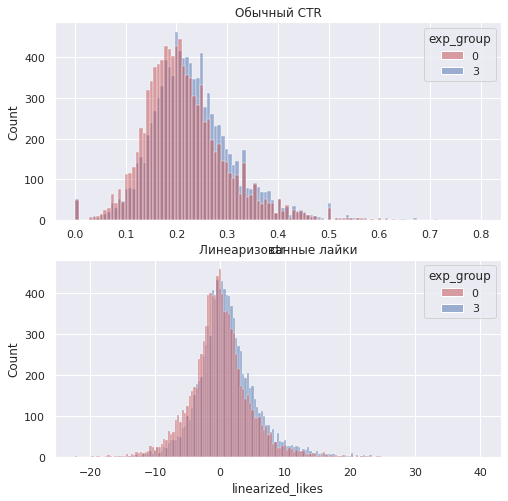

In [94]:
#Провизуализируем для ставнения обычные и линеализованные показатели для 0 и 3 группы
fig,ax =plt.subplots(2,1,figsize=(8, 8))
sns.histplot(data = df_ab_lin[df_ab_lin['exp_group'].isin([0,3])] ,
             ax=ax[0],
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False).set( title="Обычный CTR")

sns.histplot(data = df_ab_lin[df_ab_lin['exp_group'].isin([0,3])],
             ax=ax[1], 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False).set( title="Линеаризованные лайки")
plt.show()

In [95]:
print('p-value обычного CTR по тесту Стьюдента: '+ 
      str(stats.ttest_ind(df_ab_lin[df_ab_lin.exp_group == 0].ctr,
                df_ab_lin[df_ab_lin.exp_group == 3].ctr,
                equal_var=False)[1]))
print('p-value линеаризованных лайков по тесту Стьюдента: '+ 
      str(stats.ttest_ind(df_ab_lin[df_ab_lin.exp_group == 0].linearized_likes,
                df_ab_lin[df_ab_lin.exp_group == 3].linearized_likes,
                equal_var=False)[1]))

p-value обычного CTR по тесту Стьюдента: 6.216047483057877e-44
p-value линеаризованных лайков по тесту Стьюдента: 1.4918137745324434e-58


Вывод: Результат p-value стал ниже чем был следовательно тест стал более чувствительный.
Группы имеют сильное различие между собой и статистически не эквивалентны

In [96]:
print('p-value обычного CTR по методу Манна-Уитни: '+ 
      str(stats.mannwhitneyu(df_ab_lin[df_ab_lin.exp_group == 0].ctr,
                df_ab_lin[df_ab_lin.exp_group == 3].ctr)[1]))
print('p-value линеаризованных лайков по методу Манна-Уитни: '+ 
      str(stats.mannwhitneyu(df_ab_lin[df_ab_lin.exp_group == 0].linearized_likes,
                df_ab_lin[df_ab_lin.exp_group == 3].linearized_likes)[1]))

p-value обычного CTR по методу Манна-Уитни: 8.916679404235955e-57
p-value линеаризованных лайков по методу Манна-Уитни: 2.504376811309453e-65


p-value в тесте Манна-Уитни так же снизился. Следовательно этот метод работает лучше и для него.

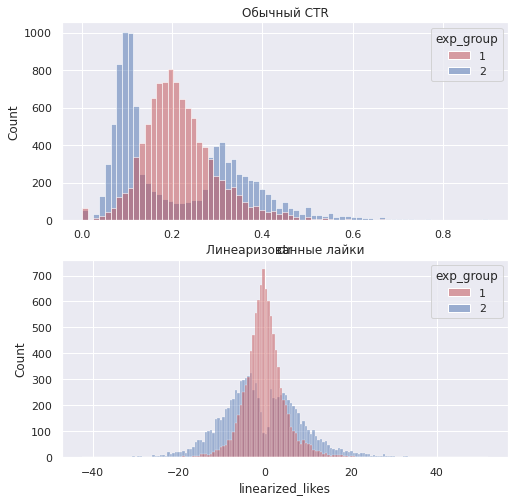

In [97]:
#Провизуализируем для ставнения обычные и линеализованные показатели для 1 и 2 группы
fig,ax =plt.subplots(2,1,figsize=(8, 8))
sns.histplot(data = df_ab_lin[df_ab_lin['exp_group'].isin([1,2])] ,
             ax=ax[0],
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False).set( title="Обычный CTR")

sns.histplot(data = df_ab_lin[df_ab_lin['exp_group'].isin([1,2])],
             ax=ax[1], 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False).set( title="Линеаризованные лайки")
plt.show()

In [98]:
print('p-value обычного CTR по тесту Стьюдента: '+ 
      str(stats.ttest_ind(df_ab_lin[df_ab_lin.exp_group == 1].ctr,
                df_ab_lin[df_ab_lin.exp_group == 2].ctr,
                equal_var=False)[1]))
print('p-value линеаризованных лайков по тесту Стьюдента: '+ 
      str(stats.ttest_ind(df_ab_lin[df_ab_lin.exp_group == 1].linearized_likes,
                df_ab_lin[df_ab_lin.exp_group == 2].linearized_likes,
                equal_var=False)[1]))

p-value обычного CTR по тесту Стьюдента: 0.685373331140751
p-value линеаризованных лайков по тесту Стьюдента: 2.9805064038668383e-09


Вывод: Результат p-value стал ниже чем был и преодолел отметку в <0,05 что доказывает статистическое различие между группами следовательно тест стал более чувствительный и точный.

In [99]:
print('p-value обычного CTR по методу Манна-Уитни: '+ 
      str(stats.mannwhitneyu(df_ab_lin[df_ab_lin.exp_group == 1].ctr,
                df_ab_lin[df_ab_lin.exp_group == 2].ctr)[1]))
print('p-value линеаризованных лайков по методу Манна-Уитни: '+ 
      str(stats.mannwhitneyu(df_ab_lin[df_ab_lin.exp_group == 1].linearized_likes,
                df_ab_lin[df_ab_lin.exp_group == 2].linearized_likes)[1]))

p-value обычного CTR по методу Манна-Уитни: 4.632205841806026e-45
p-value линеаризованных лайков по методу Манна-Уитни: 2.4030320776345276e-23


А вот в тесте Манна уитни p=value стал выше чем был, но все равно эти группы по этому методу являются статистически различными.